<a href="https://colab.research.google.com/github/OrianaMart/ECEN-403---Team-39/blob/ML/TEAM39_MLModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!unzip Training.zip #This portion unzips the folder containing the dataset images

Archive:  Training.zip
   creating: Training/
   creating: Training/Calculator/
  inflating: Training/Calculator/Explorer (1).jpeg  
  inflating: Training/Calculator/Explorer (1).jpg  
  inflating: Training/Calculator/Explorer (1).png  
  inflating: Training/Calculator/Explorer (10).jpg  
  inflating: Training/Calculator/Explorer (10).png  
  inflating: Training/Calculator/Explorer (100).jpg  
  inflating: Training/Calculator/Explorer (101).jpg  
  inflating: Training/Calculator/Explorer (102).jpg  
  inflating: Training/Calculator/Explorer (103).jpg  
  inflating: Training/Calculator/Explorer (104).jpg  
  inflating: Training/Calculator/Explorer (105).jpg  
  inflating: Training/Calculator/Explorer (106).jpg  
  inflating: Training/Calculator/Explorer (107).jpg  
  inflating: Training/Calculator/Explorer (108).jpg  
  inflating: Training/Calculator/Explorer (109).jpg  
  inflating: Training/Calculator/Explorer (11).jpg  
 extracting: Training/Calculator/Explorer (11).png  
 extracting

In [ ]:
%rm -rf Dataset2/ #This is only to be run when the file needs to be cleared out

In [2]:
import tensorflow as tf    #This section is where all the necessary imports are brought into the project
import matplotlib.pyplot as plt

In [11]:
img_height, img_width = 32,32    #Sets constant image size
batch_size = 9      #Amount of images to be processed at a given time, the lower the number the easier it is to process

train_ds = tf.keras.utils.image_dataset_from_directory(          #Set up for the training dataset, takes image directory and turns it into a dataset
    "Dataset2/Training",                                    #Sets training image directory to training dataset
    image_size = (img_height, img_width),                    #Constant image size that matches previously set size
    batch_size = batch_size                                       #Constant bach size
)
val_ds = tf.keras.utils.image_dataset_from_directory(       #Set up for the validation dataset, takes image directory and turns it into a dataset
    "Dataset2/Validation",                                      #Sets validation image directory to validation dataset
    image_size = (img_height, img_width),                        #Constant image size that matches previously set size
    batch_size = batch_size                                              #Constant bach size
)
test_ds = tf.keras.utils.image_dataset_from_directory(       #Set up for the testing dataset, takes image directory and turns it into a dataset
    "Dataset2/Testing",                                       #Sets testing image directory to testing dataset
    image_size = (img_height, img_width),                        #Constant image size that matches previously set size
    batch_size = batch_size                                     #Constant bach size
)

Found 3886 files belonging to 4 classes.
Found 3886 files belonging to 4 classes.
Found 1319 files belonging to 4 classes.


In [10]:
import os
import cv2
import imghdr

def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'/content/Dataset2/Training'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  Charger
processing class directory  MOSFET
processing class directory  Microcontroller
processing class directory  Calculator
improper image files are listed below
/content/Dataset2/Training/Calculator/Ti-CE (2).png


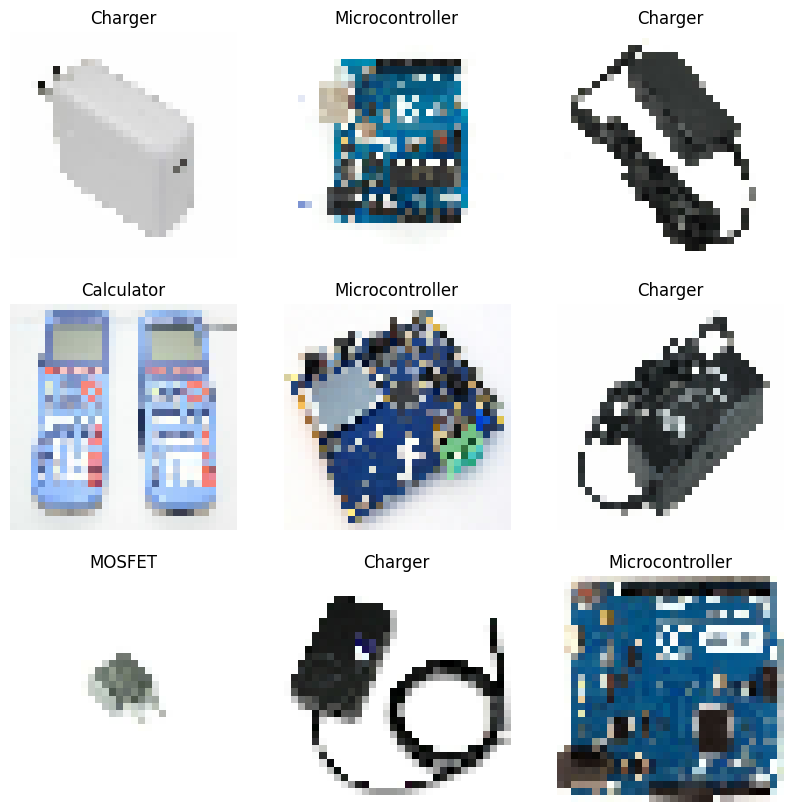

In [12]:
class_names = ["Calculator", "Charger", "MOSFET", "Microcontroller"]
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(4)
    ]
)

In [14]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

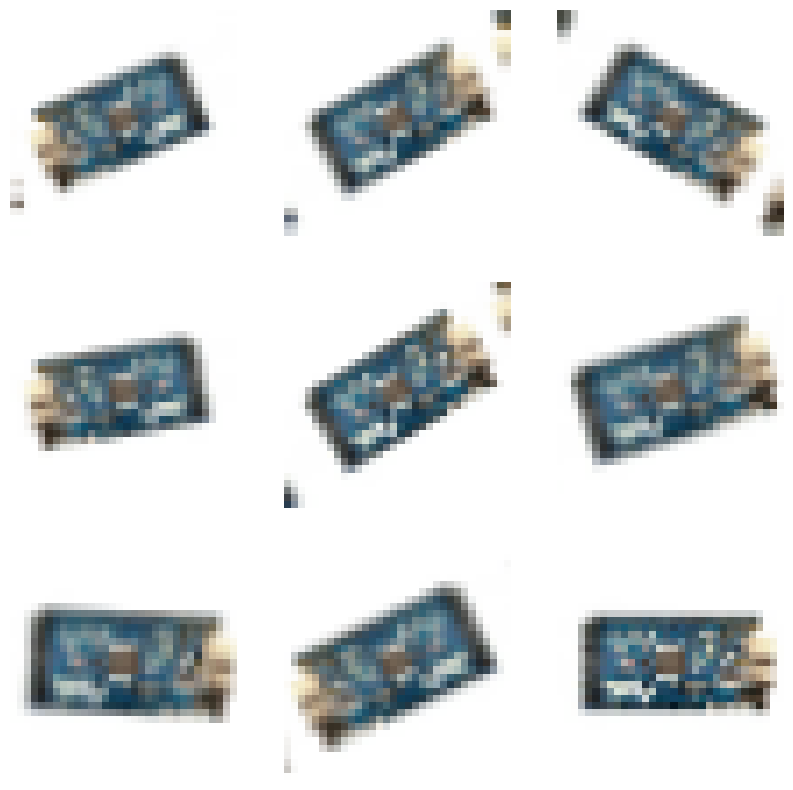

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [16]:
model.compile(
    optimizer = "adam",
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 75
)

Epoch 1/75
432/432 [==============================] - 82s 188ms/step - loss: 0.8840 - accuracy: 0.6238 - val_loss: 0.5874 - val_accuracy: 0.7903
Epoch 2/75
432/432 [==============================] - 79s 183ms/step - loss: 0.4609 - accuracy: 0.8428 - val_loss: 0.3608 - val_accuracy: 0.8762
Epoch 3/75
432/432 [==============================] - 80s 186ms/step - loss: 0.3388 - accuracy: 0.8855 - val_loss: 0.2478 - val_accuracy: 0.9171
Epoch 4/75
432/432 [==============================] - 71s 163ms/step - loss: 0.2799 - accuracy: 0.9079 - val_loss: 0.1683 - val_accuracy: 0.9465
Epoch 5/75
432/432 [==============================] - 80s 184ms/step - loss: 0.2111 - accuracy: 0.9303 - val_loss: 0.1555 - val_accuracy: 0.9501
Epoch 6/75
432/432 [==============================] - 70s 160ms/step - loss: 0.1818 - accuracy: 0.9408 - val_loss: 0.1170 - val_accuracy: 0.9653
Epoch 7/75
430/432 [============================>.] - ETA: 0s - loss: 0.1582 - accuracy: 0.9452

In [ ]:
model.evaluate(test_ds)

147/147 [==============================] - 3s 19ms/step - loss: 8.8415 - accuracy: 0.6497


[8.841479301452637, 0.6497346758842468]

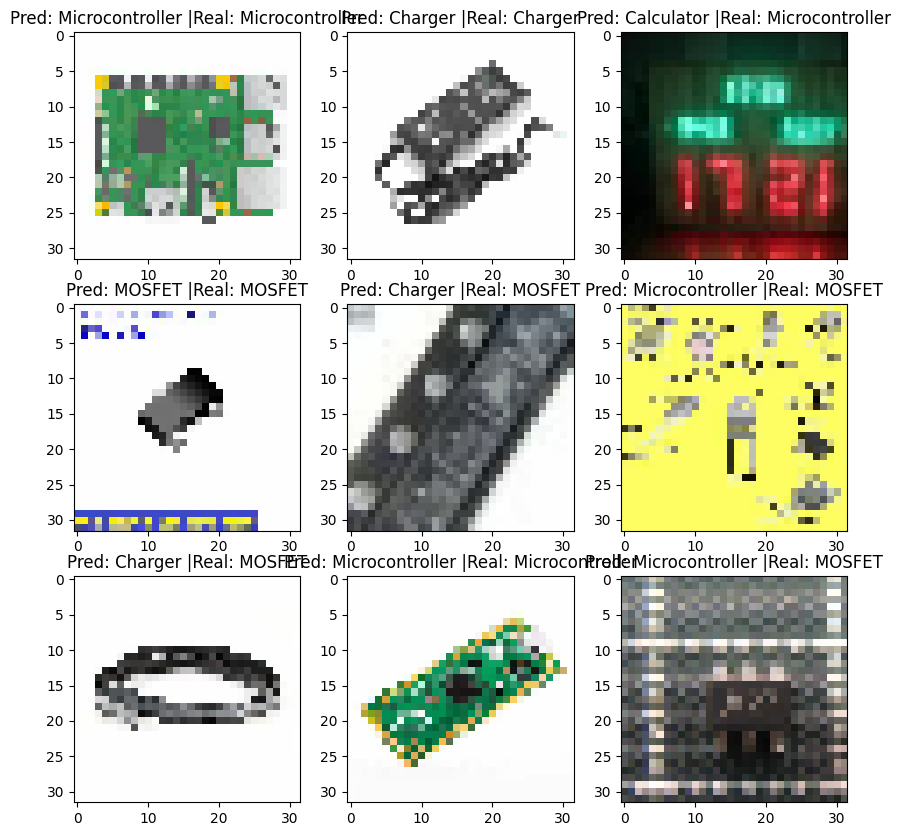

In [ ]:
import numpy

plt.figure(figsize = (10,10))
for images, labels in test_ds.take(1):
  classifications = model(images)
  #print(classifications)

  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " |Real: " + class_names[labels[i]])

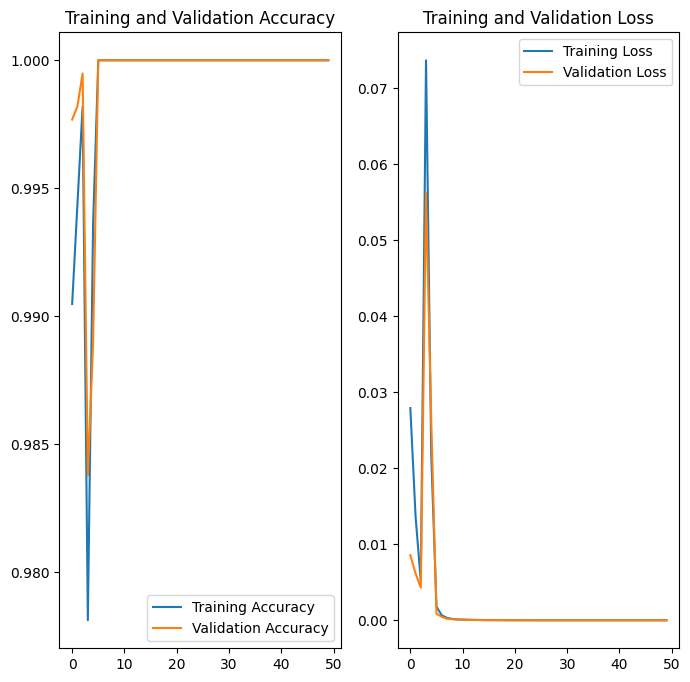

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 75
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()